## Project


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns


### Part 1 - Ocean Flow

#### Problem 1.a


In [20]:
# Time steps in the simulation
n_steps = 100

# Speed flow: 3D array with shape (Time, X coordinates, Y coordinates, 2)
speed_flow = []

# Load the X and Y data for each time step
for i in range(n_steps):

    # Load the data for X and Y
    # The data is given in a matrix with data for each position in the grid
    Vx = pd.read_csv(f'./OceanFlow/{i+1}u.csv', header=None).values
    Vy = pd.read_csv(f'./OceanFlow/{i+1}v.csv', header=None).values

    # Construct the total velocity by concatenating the X and Y components as
    # columns in a single array
    V = np.stack([Vx, Vy], axis=2)

    # Add the current time step velocity to the speed_flow array
    speed_flow.append(V)

# Convert the speed_flow list to a numpy array
Vt = np.array(speed_flow)
print("Data Shape:", Vt.shape)
print("- Timesteps:", Vt.shape[0])
print("- Y coordinates:", Vt.shape[1])
print("- X coordinates:", Vt.shape[2])
print("- Velocity components:", Vt.shape[3])

# Load the mask data
mask = pd.read_csv('./OceanFlow/mask.csv', header=None).values

# The mask is flipped in the Y axis, so we flip it back
mask = np.flip(mask, axis=0)


Data Shape: (100, 504, 555, 2)
- Timesteps: 100
- Y coordinates: 504
- X coordinates: 555
- Velocity components: 2


Provide the coordinates (in Kilometers) of the point with smallest variation in speed flow (magnitude of the vector). Hint: Recall that technically the speed flow inland is zero.

You should first calculate the magnitude for each data point, $\sqrt{u^2+v^2}$, then compute the variance across time. Some things to look out for:

Some elements do not have meaningful data (all zeros, generally land and the border of the map). Remove any locations with a variance of zero before finding the minimum.

The answer is in kilometers, as specified above, the zero-indexed element (0, 0) corresponds to (0 km, 0 km). The grid spacing is 3 km. Multiply your zero-indexed indices by 3 to get the location in kilometers.

Libraries such as pandas will load these .csv files with the first index over rows, and the second index over columns. If you want $x=6$ km and $y=3$ km and you index such an array as array[2, 1] you will get the wrong result. Double check the ordering of indices and ensure they correspond to the definition of the $x$ and $y$ axes.


Location with lowest variance: (170, 121)
Location with lowest variance: (510km, 363km)
Variance at that location: 1.2297629738694259e-13


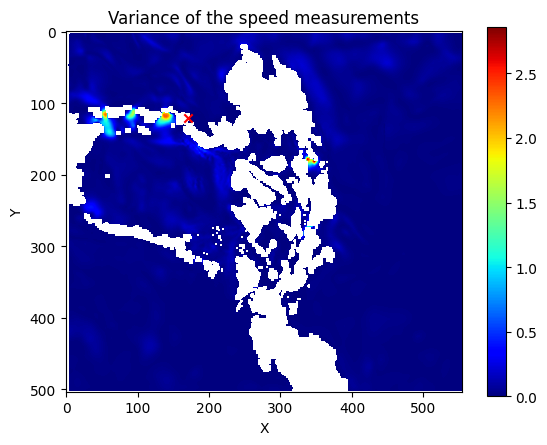

In [5]:
# Extract the X and Y velocities
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Calculate the magnitude of the velocity (speed)
speed = np.sqrt(Vx**2 + Vy**2)

# Calculate the variance of the speed measurements across all time steps
speed_var = np.nanvar(speed, axis=0)

# Remove values with variance of zero
speed_var[speed_var == 0] = np.nan

# Get the coordinates of the grid with the lowest variance
# Note:
# - np.nanargmin returns the index of the minimum value in a flattened array.
#   We use np.unravel_index to convert this index to the 2D coordinates of the
#   grid given its shape.
# - The coordinates are given in (y, x) order because columns provide X coordinates
#   and rows provide Y coordinates.
min_y, min_x = np.unravel_index(
    np.nanargmin(speed_var),
    speed_var.shape
)

# According to the instructions, the answer in kilometers can be obtained by taking
# the zero-indexed coordinate and multiplying it by 3.
min_y_km = min_y * 3
min_x_km = min_x * 3
print(f"Location with lowest variance: ({min_x}, {min_y})")
print(f"Location with lowest variance: ({min_x_km}km, {min_y_km}km)")
print(f"Variance at that location: {speed_var[min_y, min_x]}")

# ==================== PLOT ==================== #

# Plot the variance of the speed measurements
plt.imshow(speed_var, cmap='jet')
plt.colorbar()
plt.title('Variance of the speed measurements')
plt.xlabel('X')
plt.ylabel('Y')

# Add an indicator for the location with the lowest variance
plt.scatter(min_x, min_y, marker='x', color='red')
plt.show()

#### Problem 1.b

Provide the coordinates (in Kilometers) and the time stamp (in hours), of the point where the flow has its maximum x-axis velocity (the maximum signed value).

Something to look out for:

- One answer is in hours, as specified above, the zero-indexed element 0 corresponds to 0 hrs. The time spacing is 3 hours. Multiply your zero-indexed time index by 3 to get the location in hours.


In [6]:
# Get the X axis velocity
Vx = Vt[:, :, :, 0]

# Get the maximum value X-axis value across all time steps
# Continue to keep in mind that the X and Y coordinates are reversed in the
# array shape (rows are Y coordinates and columns are X coordinates)
Vx_t_max, Vx_y_max, Vx_x_max = np.unravel_index(
    np.argmax(Vx),
    Vx.shape
)

# Multiply all max quantities by 3 to get the values in kilometers and hours
Vx_x_max_km = Vx_x_max * 3
Vx_y_max_km = Vx_y_max * 3
Vx_t_max_h = Vx_t_max * 3

print(f"Maximum X-axis velocity: {Vx[Vx_t_max, Vx_y_max, Vx_x_max]}")
print(f"Location of max X-axis velocity: ({Vx_x_max_km}km, {Vx_y_max_km}km)")
print(f"Time of max X-axis velocity: {Vx_t_max_h}h")

Maximum X-axis velocity: 5.7993
Location of max X-axis velocity: (1041km, 543km)
Time of max X-axis velocity: 84h


#### Problem 1.c

Take the average of the velocity vector over all time and positions, so that you get an overall average velocity for the entire data set.

Note you should average over land positions for this problem, do not attempt to remove them from the average. (You may want to consider in your own time how this might bias the result.)


In [7]:
# Get the X and Y axis velocities
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Calculate the average velocity for each component
Vx_avg = np.nanmean(Vx)
Vy_avg = np.nanmean(Vy)

print(f"Average X-axis velocity: {Vx_avg}")
print(f"Average Y-axis velocity: {Vy_avg}")


Average X-axis velocity: -0.09366228934616833
Average Y-axis velocity: -0.03548388738810676


#### Problem 3.a (10 points)


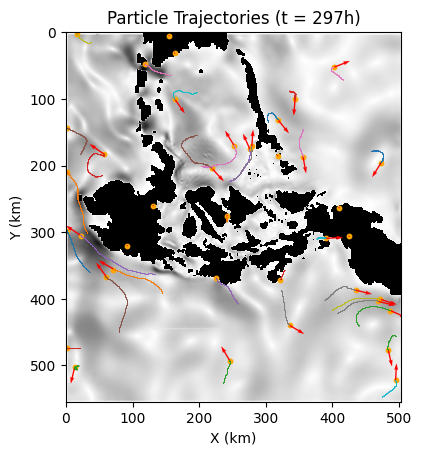

In [76]:
from typing import Literal

# ============================================== #
# SIMULATION                                     #
# ============================================== #

# Number of timesteps
T = 100

# Number of particles to simulate
N = 40

# Time step
# (Number of hours between each time step)
epsilon = 3

# =============== PRE-PROCESSING =============== #

# Get the max and min X and Y coordinates
Xaxis_min = 0
Xaxis_max = Vt.shape[2]
Yaxis_min = 0
Yaxis_max = Vt.shape[1]

# Generate random X and Y coordinates for the particles
np.random.seed(42069)
particles_x_pos = np.random.randint(Xaxis_min, Xaxis_max, size=N)
particles_y_pos = np.random.randint(Yaxis_min, Yaxis_max, size=N)

# Concatenate the X and Y coordinates as columns in a single array
Xt = np.stack(
    [particles_x_pos, particles_y_pos],
    axis=1
)

# Convert the X and Y coordinates to kilometers
# (They are initially in indexes that go from 0 upwards. We know each index
# represents 3 kilometers, so we multiply by 3 to get the kilometers)
Xt = Xt * 3

# =============== SIMULATION LOOP ============== #

# History of the positions of the particles
X_history = []
X_history.append(Xt)

# History of the particle velocities
V_history = []
V_history.append(np.zeros((N, 2)))

for t in range(T):

    # Get the surrogate X and Y positions for the particles
    # (Closest integer coordinates after converting back to indexes by dividing by 3)
    X_surrogate = np.round(Xt / 3).astype(int)

    # Get the X and Y velocities for the surrogate positions
    # (Vt is already in kilometers per hour)
    V_surrogate = Vt[t, X_surrogate[:, 1], X_surrogate[:, 0], :]

    # Update the positions of the particles
    Xt = Xt + V_surrogate * epsilon

    # Add the new positions and velocities to the history
    X_history.append(Xt)
    V_history.append(V_surrogate)

# Convert the histories to a numpy array
X_history = np.array(X_history)
V_history = np.array(V_history)

# Convert the X_history array back to indexes
# (divide by 3 and round to nearest integer)
X_history = np.round(X_history / 3).astype(int)

# ============================================== #
# PLOT                                           #
# ============================================== #

# Time step to plot
t = 99

# ==================== SPEED =================== #

# Get the magnitude of the velocity (speed)
Vx = Vt[:, :, :, 1]
Vy = Vt[:, :, :, 0]
speed = np.sqrt(Vx**2 + Vy**2)

# The last two dimensions of the speed are flipped, so we need to transpose
# them to get the correct shape in the map ([time, Y, X] -> [time, X, Y])
speed = np.transpose(speed, (0, 2, 1))

# Plot the speed at the given time step (inverted grey scale)
plt.imshow(speed[t, :, :], cmap='gray_r')

# ================ TRAJECTORIES ================ #

# Get the X and Y coordinates of the particles
X_coords = X_history[:t, :, 1]
Y_coords = X_history[:t, :, 0]

# Plot the trajectories of the particles up to the given time step
for i in range(N):
    plt.plot(X_coords, Y_coords, linewidth=0.1)

# Plot the end positions of the particles as yellow dots
plt.scatter(
    X_coords[-1], Y_coords[-1],
    marker='o',
    color='orange',
    label='End position',
    s=10
)

# ================ END VELOCITY ================ #

# Get the end positions of the particles
Xt_last = X_history[t, :, :]
PosX_last = Xt_last[:, 1]
PosY_last = Xt_last[:, 0]

# Get the end velocities of the particles
# (Since we already converted the X_history array back to indexes, the positions
# can be used to directly index the Vx and Vy arrays)
Vx_end = V_history[t-1, :, 1]
Vy_end = V_history[t-1, :, 0]

# The Y-axis velocities are flipped, so we need to flip them back
Vy_end = -Vy_end

# # Get the magnitude (speed) of the end velocities
S = np.sqrt(Vx_end**2 + Vy_end**2)

# # If the magnitude of the end velocity is 0, set it to 1 to avoid division by 0
S[S == 0] = 1

# Normalize the end velocities
Vx_end = (Vx_end / S)
Vy_end = (Vy_end / S)

# Plot the direction of the velocity at the end of the simulation
# (Divide by 3 to convert from km/h to index/h)
plt.quiver(
    PosX_last, PosY_last,
    Vx_end, Vy_end,
    color='red',
    scale=20,
    width=0.004,
)

# ==================== LAND ==================== #

# Create a custom color map that appears black for 1 and transparent for 0
custom_cmap = matplotlib.colors.ListedColormap([
    (0, 0, 0, 1),
    (0, 0, 0, 0)
])

# The land mask is also flipped, so we need to transpose its last
# two dimensions to get the correct shape in the map ([Y, X] -> [X, Y])
flipped_mask = np.transpose(mask, (1, 0))

# Plot the mask of the land in black
plt.imshow(flipped_mask, cmap=custom_cmap)

# ============= FINAL PLOT SETTINGS ============ #

# plt.legend(fontsize=8)
plt.title(f'Particle Trajectories (t = {t*3}h)')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\eddysanoli\AppData\Local\Temp\ipykernel_5952\4261115404.py:81: RuntimeWarning: invalid value encountered in divide
  Vx_end_norm = Vx_end / np.sqrt(Vx_end**2 + Vy_end**2)
C:\Users\eddysanoli\AppData\Local\Temp\ipykernel_5952\4261115404.py:82: RuntimeWarning: invalid value encountered in divide
  Vy_end_norm = Vy_end / np.sqrt(Vx_end**2 + Vy_end**2)


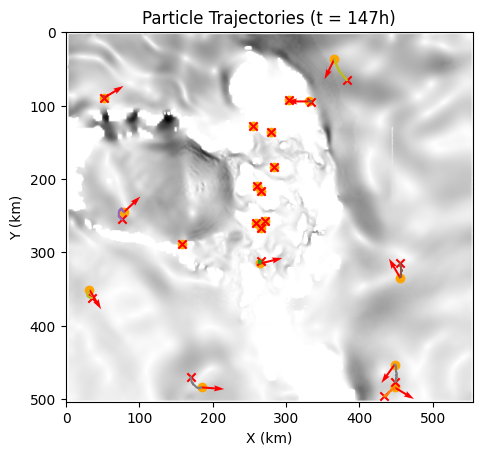

In [129]:
# ============================================== #
# ANIMATION                                      #
# ============================================== #

# Create a figure and axis
fig, ax = plt.subplots()


def init():
    """
    Init function for the animation 
    """

    # Plot the speed at the given time step (inverted grey scale)
    ax.imshow(speed[0, :, :], cmap='gray_r')

    # Plot the land mask
    ax.imshow(mask, cmap=custom_cmap)

    # Plot the starting positions of the particles
    ax.scatter(
        X_history[0, :, 0],
        X_history[0, :, 1],
        marker='x',
        color='red',
        label='Starting position'
    )

    # Additional plot settings
    ax.set_title(f'Particle Trajectories (t = {0}h)')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')

    return fig,


def animate(i):
    """
    Animation function for the animation
    """

    # Clear the axis
    ax.clear()

    # Plot the land mask
    ax.imshow(mask, cmap=custom_cmap, alpha=0.5)

    # Plot the speed at the given time step (inverted grey scale)
    ax.imshow(speed[i, :, :], cmap='gray_r')

    # Plot the trajectories of the particles up to the given time step
    for j in range(N):
        ax.plot(
            X_history[:i, j, 0],
            X_history[:i, j, 1],
        )

    # Plot the end positions of the particles as yellow dots
    ax.scatter(
        X_history[i, :, 0],
        X_history[i, :, 1],
        marker='o',
        color='orange',
        label='End position'
    )

    # Plot the starting positions of the particles
    ax.scatter(
        X_history[0, :, 0],
        X_history[0, :, 1],
        marker='x',
        color='red',
        label='Starting position'
    )

    # Get the end velocities of the particles
    Vx_end = Vx[i, X_history[i, :, 1], X_history[i, :, 0]]
    Vy_end = Vy[i, X_history[i, :, 1], X_history[i, :, 0]]

    # Normalize the end velocities
    Vx_end_norm = Vx_end / np.sqrt(Vx_end**2 + Vy_end**2)
    Vy_end_norm = Vy_end / np.sqrt(Vx_end**2 + Vy_end**2)

    # Plot the direction of the velocity at the end of the simulation
    # (Divide by 3 to convert from km/h to index/h)
    ax.quiver(
        X_history[i, :, 0],
        X_history[i, :, 1],
        Vx_end_norm,
        Vy_end_norm,
        color='red',
        width=0.005,
    )

    # Additional plot settings
    ax.set_title(f'Particle Trajectories (t = {(i)*3}h)')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')

    return fig,


# Create the animation
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=50,
    interval=100,
    blit=True
)

# Save the animation
anim.save('animation.gif', writer='imagemagick')
